# Parsing Realtime Metrics
Author: John Vivian

Metrics from Toil runs are dumped to a file and must be processed into sparse dataframes before they can be plotted or analyzed.  Metrics analyzed are generated from [this automation pipeline script](https://github.com/jvivian/one_off_scripts/blob/master/automated_scaling_tests.py).  This automation pipeline spins up a cluster, launches the pipeline, then grabs metrics every hour while monitoring instances as they grow idle and terminating them. 

Plots are generated by taking the mean and standard deviation of the timestamp columns.

Cost is estimated by obtaining the start/stop time for each instance, scraping the spot price history for that time period, calculating the total cost for that individual instance, and summing over all instances.

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import itertools
import numpy as np
from datetime import datetime
from tqdm import tqdm
import logging
import time
import boto.ec2
logging.basicConfig(level=logging.INFO)

In [2]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

## Preprocessing
First locate the files we want to analyze.

In [49]:
runs = []
for root, dirs, files in os.walk('.'):
    runs.extend(dirs)
runs = [x for x in runs if 'scaling' in x]

In [50]:
metrics = {}
for r in runs:
    metrics[r.split('_')[-1]] = [os.path.join(r, x) for x in os.listdir(r) if '.csv' in x]

For all of these metrics, which consist of lines that contain the **instance ID**, **value**, and **timestamp**, we must create a sparse matrix for each metric, where each row belongs to an instance and the columns are timestamps. 

In [6]:
def create_sparse_matrix(df):
    frames = []
    # Make the dataframe searchable by instance ID
    df.sort(columns=['id'], inplace=True)
    df.set_index(keys=['id'], drop=False, inplace=True)
    names=df['id'].unique().tolist()
    # For each instance id, construct a 1D vector of values
    for instance_id in tqdm(names):
        instance_df = df.loc[df['id'] == instance_id]
        instance_df.sort('timestamp', inplace=True)
        instance_df = instance_df.transpose()
        instance_df.columns = instance_df.iloc[2]
        instance_df.drop(['timestamp', 'id'], inplace=True)
        instance_df.index = [instance_id]
        # This line removes duplicate timestamp intervals
        frames.append(instance_df.T.groupby(level=0).first().T)
    return pd.concat(frames) 

Create a spare matrix for every metric and store in a dictionary.

In [55]:
metrics['scaling-gtex-400']

['6c7f8f8f-28e5-4132-92b0-086c08e4f111_2016-02-06_scaling-gtex-400/CPUUtilization.csv',
 '6c7f8f8f-28e5-4132-92b0-086c08e4f111_2016-02-06_scaling-gtex-400/DiskReadOps.csv',
 '6c7f8f8f-28e5-4132-92b0-086c08e4f111_2016-02-06_scaling-gtex-400/DiskUsage_mnt_ephemeral.csv',
 '6c7f8f8f-28e5-4132-92b0-086c08e4f111_2016-02-06_scaling-gtex-400/DiskWriteOps.csv',
 '6c7f8f8f-28e5-4132-92b0-086c08e4f111_2016-02-06_scaling-gtex-400/MemUsage.csv',
 '6c7f8f8f-28e5-4132-92b0-086c08e4f111_2016-02-06_scaling-gtex-400/NetworkIn.csv',
 '6c7f8f8f-28e5-4132-92b0-086c08e4f111_2016-02-06_scaling-gtex-400/NetworkOut.csv']

In [516]:
matrices = {}
for metric in metrics['scaling-gtex-400']:
    df = pd.read_csv( metric, sep='\t', names=['id', 'value', 'timestamp'] )
    matrices[os.path.basename(metric).split('.')[0]] = create_sparse_matrix(df)

## Plotting
We'll now iterate through this dictionary and produce a subplot for each metric. Lastly, we'll compute the number of active nodes at each given time point, translate that into number of cores, and plot it. 

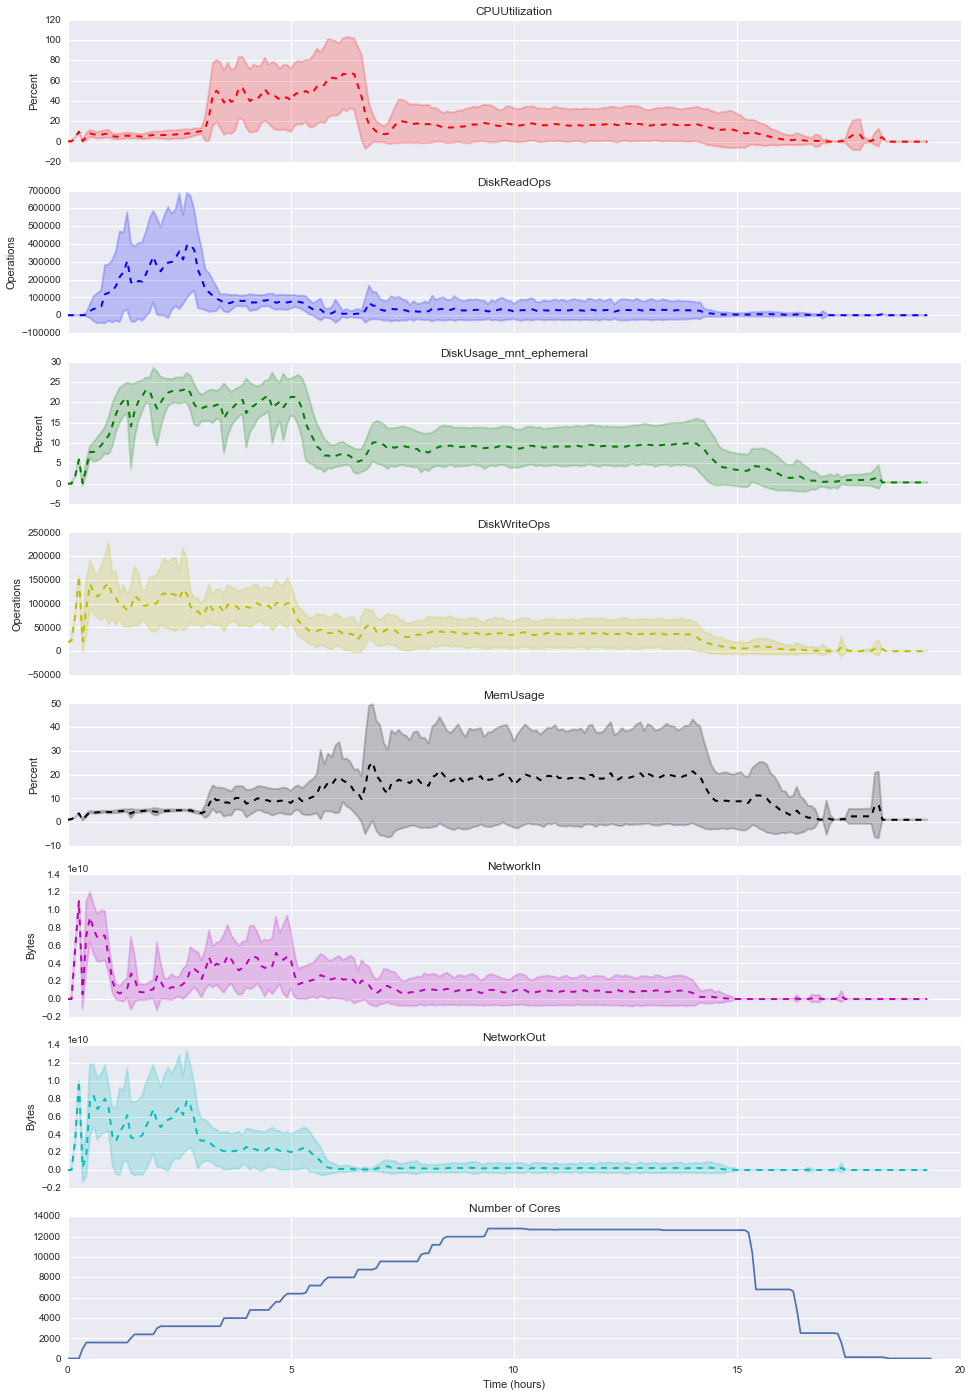

In [526]:
def plot_metrics(metric_dictionary):
    colors = itertools.cycle(["r", "b", "g", 'y', 'k', 'm', 'c'])
    ylabels = ['Percent', 'Operations', 'Percent', 'Operations', 'Percent', 'Bytes', 'Bytes']
    num_workers = [] 

    # Dynamically generate subplots for DRYness and flexibility
    metric_info = zip(sorted(matrices.keys()), ylabels)
    f, axes = plt.subplots(len(metric_info)+1, sharex=True, figsize=(16, 24))
    for i, mi in enumerate(metric_info):
        c = next(colors)
        metric, ylabel = mi
        matrix = matrices[metric]
        mean = matrix.mean()
        std = matrix.std().fillna(0)
        x = [t*5.0/60 for t in xrange(len(mean))]
        axes[i].plot(x, mean, linewidth=2, linestyle='dashed', color=c)
        axes[i].fill_between(x, mean-std, mean+std, alpha=0.2, linewidth=2, color=c);
        axes[i].set_title(metric)
        axes[i].set_ylabel(ylabel)
        num_workers.append(matrix.count())
    # We'll calculate the number of workers by taking the max "count" of each metric's timestamp
    num_workers = pd.DataFrame(num_workers)
    num_instances = num_workers.max()*32
    x = [t*5.0/60 for t in xrange(len(num_instances))]
    axes[-1].plot(x, num_instances)
    axes[-1].set_title("Number of Cores")
    axes[-1].set_xlabel('Time (hours)')
    plt.show();

## Calculate Costs
We would also like to compute the costs for a given run. This can be done accurately by looking at each instance id's start/stop time, querying amazon's spot market prices for that time frame, and computing a total cost.

In [13]:
def calculate_cost(conn, instance_type='c3.8xlarge', avail_zone='us-west-2a',
                   start_time=None, end_time=None, region='us-west-2'):
    # Some values
    logging.info('Calculating costs...')
    total, n = 0.0, 0
    min_time = float("inf")
    # Connect to EC2 -- requires ~/.boto
    # Get prices for instance, AZ and time range
    prices = conn.get_spot_price_history(instance_type=instance_type, start_time=start_time,
                                         end_time=end_time, availability_zone=avail_zone)
    # Output the prices
    for price in prices:
        total += price.price
        n += 1
    # Difference b/w first and last returned times
    stop = time.mktime(datetime.strptime(end_time, "%Y-%m-%dT%H:%M:%S").timetuple())
    start = time.mktime(datetime.strptime(start_time, "%Y-%m-%dT%H:%M:%S").timetuple())
    time_diff = (stop - start) / 3600
    return str(time_diff * (total/n)), str(total / n)

def convert_str_to_datetime(str_time):
    str_time = str_time.replace('-', '').replace(':', '').replace(' ', '')
    str_time = datetime.strptime( str_time, '%Y%m%d%H%M%S')
    return str_time.isoformat()

In [ ]:
costs = []
conn = boto.ec2.connect_to_region('us-west-2')
for metric in matrices:
    cost = 0
    matrix = matrices[metric]
    for row in tqdm(matrix.iterrows()):
        row = row[1].dropna()
        start = convert_str_to_datetime(min(row.index))
        end = convert_str_to_datetime(max(row.index))
        total, avg = calculate_cost(conn, start_time=start, end_time=end)
        cost += float(total)
        print 'Total: {}\tAverage: {}'.format(total, avg)
    costs.append(cost)
print 'Run cost ~${}'.format(round(np.median(costs), 2))

Since this run consisted of 2,546 samples, our cost per sample was: **$1.02**, a massive improvement over previously used RNA-seq pipelines. 

# Toil Recompute

In [7]:
runs = []
for root, dirs, files in os.walk('.'):
    runs.extend(dirs)
runs = [x for x in runs if 'toil' in x]

In [8]:
metrics = {}
for r in runs:
    metrics[r.split('_')[-1]] = [os.path.join(r, x) for x in os.listdir(r) if '.csv' in x]

In [9]:
matrices = {}
start = time.time()
for metric in metrics['toil-recompute']:
    df = pd.read_csv( metric, sep='\t', names=['id', 'value', 'timestamp'] )
    matrices[os.path.basename(metric).split('.')[0]] = create_sparse_matrix(df)
print 'Computing matrices took: {} minutes for {} metrics'.format((time.time() - start) / 60, len(matrices.keys()))

  0%|          | 0/3267 [00:00<?, ?it/s]/Users/Jvivian/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:2915: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  inplace=inplace, kind=kind, na_position=na_position)
                                                   

Computing matrices took: 39.9259982665 minutes for 8 metrics


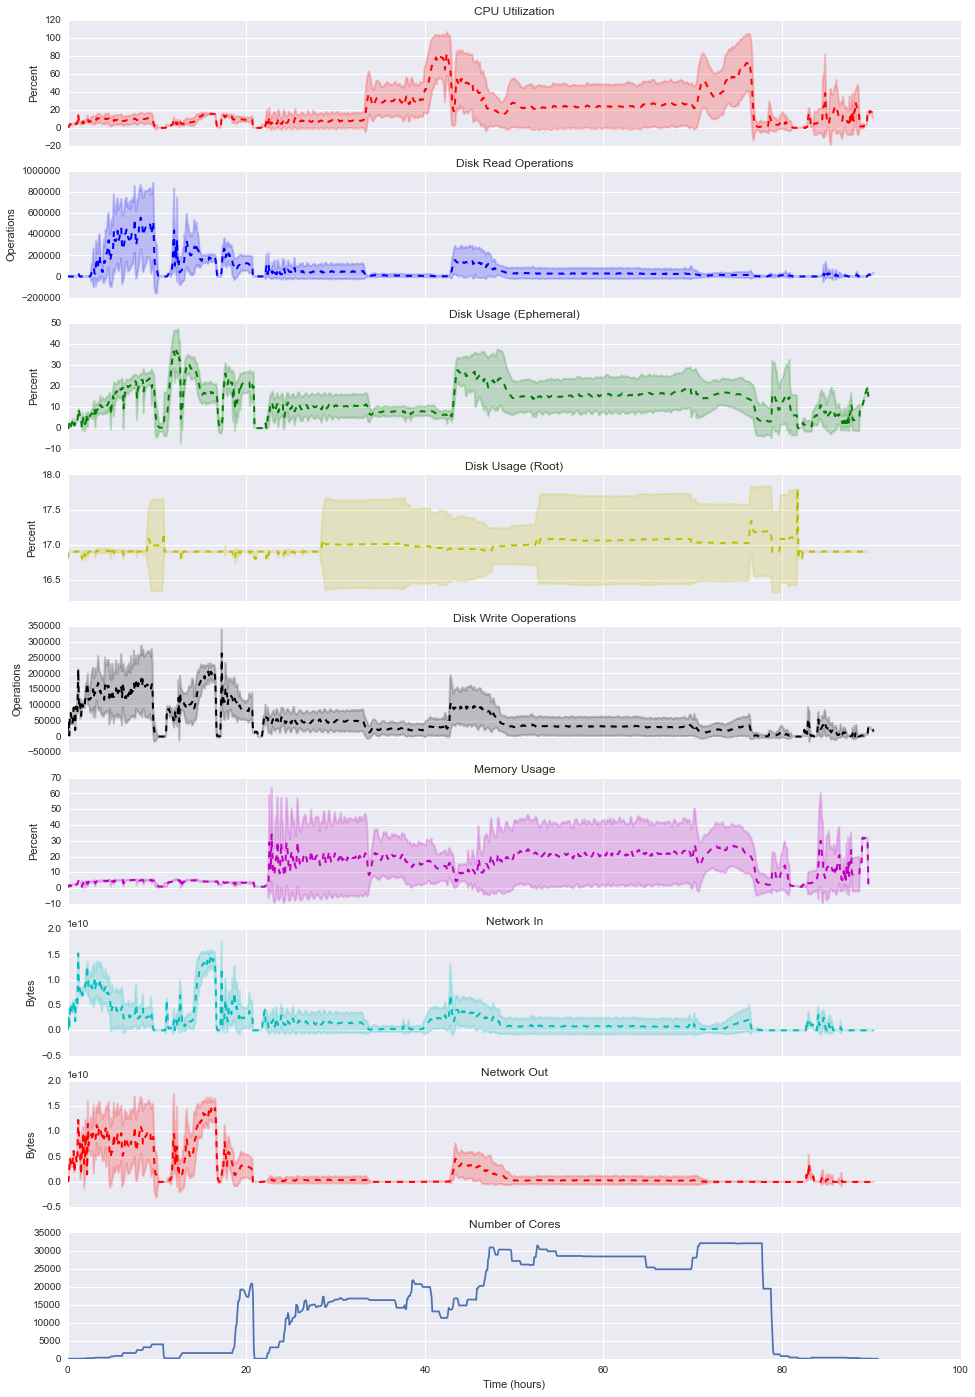

In [15]:
colors = itertools.cycle(["r", "b", "g", 'y', 'k', 'm', 'c'])
ylabels = ['Percent', 'Operations', 'Percent', 'Percent', 'Operations', 'Percent', 'Bytes', 'Bytes']
titles = ['CPU Utilization', 'Disk Read Operations', 'Disk Usage (Ephemeral)', 'Disk Usage (Root)', 
         'Disk Write Ooperations', 'Memory Usage', 'Network In', 'Network Out']
num_workers = [] 

# Dynamically generate subplots for DRYness and flexibility
metric_info = zip(sorted(matrices.keys()), ylabels, titles)
f, axes = plt.subplots(len(metric_info)+1, sharex=True, figsize=(16, 24))
for i, mi in enumerate(metric_info):
    c = next(colors)
    metric, ylabel, title = mi
    matrix = matrices[metric]
    mean = matrix.mean()
    std = matrix.std().fillna(0)
    x = [t*5.0/60 for t in xrange(len(mean))]
    axes[i].plot(x, mean, linewidth=2, linestyle='dashed', color=c)
    axes[i].fill_between(x, mean-std, mean+std, alpha=0.2, linewidth=2, color=c);
    axes[i].set_title(title)
    axes[i].set_ylabel(ylabel)
    num_workers.append(matrix.count())
# We'll calculate the number of workers by taking the max "count" of each metric's timestamp
num_workers = pd.DataFrame(num_workers)
num_instances = num_workers.max()*32
x = [t*5.0/60 for t in xrange(len(num_instances))]
axes[-1].plot(x, num_instances)
axes[-1].set_title("Number of Cores")
axes[-1].set_xlabel('Time (hours)')
plt.show();

# Cost
The Toil recompute used different instance types as well as different availablility zones. We'll create a mapping dictionary to approximate cost. 

In [16]:
zone_map = {}
type_map = {}

In [17]:
with open('instance_mapping_sorted.tsv', 'r') as f:
    for line in f:
        line = line.strip().split()
        if len(line)  == 10:
            zone_map[line[6]] = line[-1]
        elif len(line) == 11:
            zone_map[line[6]] = line[-1]
            type_map[line[6]] = line[7]

In [18]:
costs = []
conn = boto.ec2.connect_to_region('us-west-2')
for metric in matrices:
    cost = 0
    matrix = matrices[metric]
    for row in tqdm(matrix.iterrows()):
        try:
            instance_type = type_map[row[0]]
        except:
            instance_type = 'c3.8xlarge'
        try:
            zone = zone_map[row[0]]
        except:
            zone = 'us-west-2a'
        row = row[1].dropna()
        start = convert_str_to_datetime(min(row.index))
        end = convert_str_to_datetime(max(row.index))
        total, avg = calculate_cost(conn, start_time=start, end_time=end, region=zone, instance_type=instance_type)
        cost += float(total)
    print 'metric: {} Cost: {}'.format(metric, cost)
    costs.append(cost)
print costs

metric: MemUsage Cost: 22690.4293669
metric: CPUUtilization Cost: 26070.6229126


metric: NetworkIn Cost: 26070.347027


metric: DiskUsage_root Cost: 22690.3328151


metric: NetworkOut Cost: 26070.5147659


metric: DiskUsage_mnt_ephemeral Cost: 22687.9543414


metric: DiskReadOps Cost: 26070.6669982


metric: DiskWriteOps Cost: 26070.5739263
[22690.429366921966, 26070.622912591916, 26070.347026973275, 22690.332815070116, 26070.51476590607, 22687.95434139742, 26070.666998221957, 26070.57392630678]


## Survival Plot of Instances over time
For this we'll need one of our metric matrices

In [58]:
fpath = 'a1507b24-89e4-42bb-aa6d-3091d118567a_2016-02-09_toil-recompute/CPUUtilization.csv'
df = pd.read_csv( fpath, sep='\t', names=['id', 'value', 'timestamp'] )
df = create_sparse_matrix(df)

Well, that was a big waste of time. Easiest to just model as a boxplot.

(-5, 60)

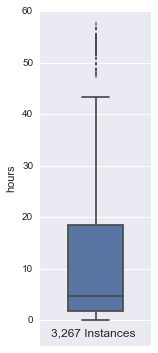

In [272]:
plt.figure(figsize=(2,6))
sns.boxplot(new_df['sums'] / 12, orient='v', width=0.5, fliersize=2)
plt.ylabel('hours')
plt.text(-0.4,-3,'3,267 Instances', fontsize=12)
plt.ylim([-5,60])

## Toil Recompute Plots

In [9]:
fpath = 'a1507b24-89e4-42bb-aa6d-3091d118567a_2016-02-09_toil-recompute/CPUUtilization.csv'
df = pd.read_csv( fpath, sep='\t', names=['id', 'value', 'timestamp'] )

In [10]:
matrix = create_sparse_matrix(df)

  0%|          | 0/3267 [00:00<?, ?it/s]/Users/Jvivian/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:2915: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  inplace=inplace, kind=kind, na_position=na_position)


In [16]:
conn = boto.ec2.connect_to_region('us-west-2')
cost = 0
averages = []
for row in tqdm(matrix.iterrows()):
    try:
        instance_type = type_map[row[0]]
    except:
        instance_type = 'c3.8xlarge'
    try:
        zone = zone_map[row[0]]
    except:
        zone = 'us-west-2a'
    row = row[1].dropna()
    start = convert_str_to_datetime(min(row.index))
    end = convert_str_to_datetime(max(row.index))
    total, avg = calculate_cost(conn, start_time=start, end_time=end, region=zone, instance_type=instance_type)
    cost += float(total)
    averages.append(avg)
print cost, np.mean([float(x) for x in averages])

 26070.6229126 0.703179443894


In [33]:
np.std([float(x) for x in averages])

0.15739628684621687

## Size of Cluster Over Time

In [19]:
num_cores = matrix.count()*32

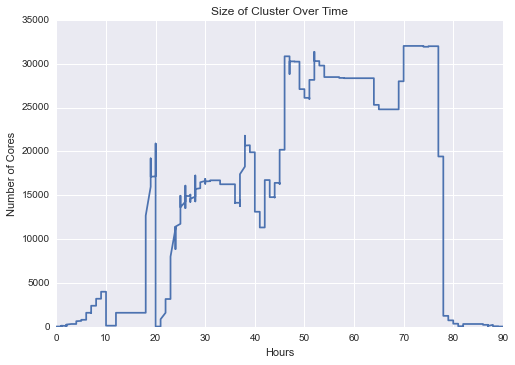

In [20]:
plt.plot([x/12 for x in xrange(len(num_cores))], num_cores)
plt.ylabel('Number of Cores')
plt.xlabel('Hours')
plt.title('Size of Cluster Over Time');

## Cumulative Number of Cores Over Time

In [21]:
def cumsum(l):
    total = 0
    new_l = []
    prev = 0
    for i in l:
        total += i - prev if i - prev > 0 else 0
        new_l.append(total)
        prev = i
    return new_l

In [22]:
cum_cores = cumsum(num_cores)

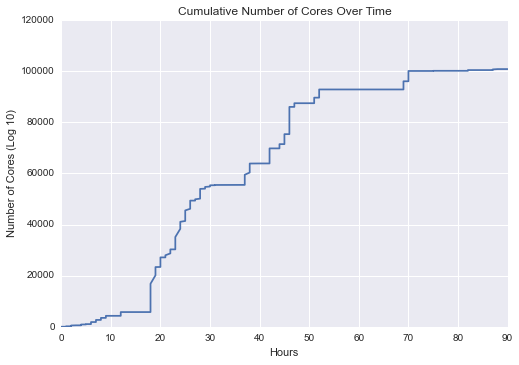

In [23]:
plt.plot([x/12 for x in xrange(len(cum_cores))], cum_cores)
plt.ylabel('Number of Cores (Log 10)')
plt.xlabel('Hours')
plt.title('Cumulative Number of Cores Over Time');

## Both Plots with Shared Axes

(-0.5, 105)

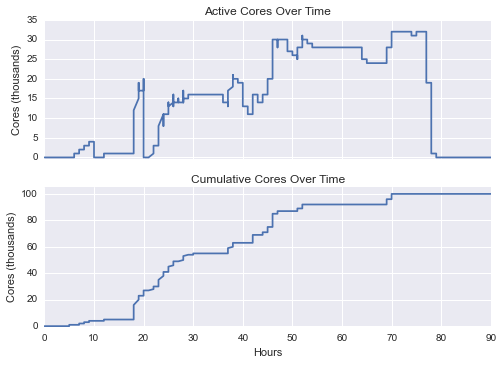

In [161]:
sns.set_style('darkgrid')
f, (ax, ax1) = plt.subplots(2, sharex=True)
ax.plot([x/12 for x in xrange(len(num_cores))], [x/1000 for x in num_cores])
ax1.plot([x/12 for x in xrange(len(cum_cores))], [x/1000 for x in cum_cores])
ax.set_ylabel('Cores (thousands)')
ax.set_title('Active Cores Over Time')
ax1.set_ylabel('Cores (thousands)')
ax1.set_title('Cumulative Cores Over Time')
ax1.set_xlabel('Hours');
ax.set_ylim([-.5,35])
ax1.set_ylim([-.5,105])

## Cost per Sample by Log of Cores

In [34]:
nodes = [1, 10, 100, 500, 1000]
cgl_cost = [4, 3, 3, 3]
cgl_spot = [1.50, 1, 1, 1.02, 1.30]
unc_cost = [42, 40, 40]
spot_market = [.33, .33, .33, .33, .70]
cores = [32*x for x in nodes]

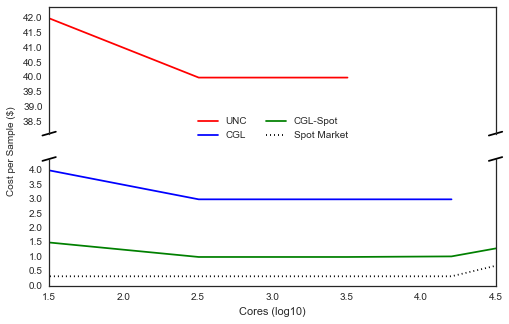

In [40]:
sns.set_style("white")
f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8,5))
l1, = ax2.plot(np.log10(cores), cgl_spot, color='green')
l2, = ax2.plot(np.log10(cores[:-1]), cgl_cost, color='blue')
l3, = ax2.plot(np.log10(cores), spot_market, ls='dotted', color='black')
l4, = ax.plot(np.log10(cores[:-2]), unc_cost, color='red')
# Set Y-lim
ax.set_ylim(38.1, 42.4)
ax2.set_ylim(0, 4.4)
# Hide Spines
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
# ax.xaxis.tick_top()
# ax.tick_params(labeltop='off')
ax2.xaxis.tick_bottom()
# Make Diagonals
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
# Legend
lines = [l1, l2, l3, l4]
labels = ['CGL-Spot', 'CGL', 'Spot Market', 'UNC']
f.legend( (l4, l2, l1, l3),  ('UNC','CGL', 'CGL-Spot', 'Spot Market'), bbox_to_anchor=(0.62, 0.60), ncol=2)
f.text(0.06, 0.5, 'Cost per Sample ($)', ha='center', va='center', rotation='vertical')
ax2.set_xlabel('Cores (log10)')
ax.set_xlim([1.5, 4.5])

`¯\_(ツ)_/¯`